This notebook contains the python script to recreate the results from: ##insert doi

It is split into the following sections:

* Missing Values Analysis

* Imputation Analysis

* Predictive Modelling

# Missing Values Analysis

This notebook examines the nature of missing values in our data applying significance testing to assess MAR, MCAR and MNAR.

In [1]:
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
import numpy as np
import statsmodels.stats.api as sms
from sklearn import linear_model
import statsmodels.api as sm

/home/emily/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Analyse Missing vs. Non-Missing Data

In [8]:
y = [1 if i <= 1 else 0 for i in data['gco']]
data['outcome_missing'] = y

### Test Significance in Categorical Variables between non-missing and missing patients

In [9]:
### counts have been taken from R-script

# Gender
gender = [ [ 9, 29 ], [ 7, 10 ] ]
chi2, p, ddof, expected = scipy.stats.chi2_contingency( gender )
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
print( msg.format( chi2, p, ddof ) )

# TH
TH = [ [ 32, 62 ], [ 10, 7 ] ]
chi2, p, ddof, expected = scipy.stats.chi2_contingency( TH )
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
print( msg.format( chi2, p, ddof ) )

# ReAn Location
ReAn = [ [ 83, 32 ], [ 11, 4 ] ]
chi2, p, ddof, expected = scipy.stats.chi2_contingency( ReAn )
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
print( msg.format( chi2, p, ddof ) )

# FirstRhy
FirstRhy = [ [ 41, 58 ], [ 2, 11 ] ]
chi2, p, ddof, expected = scipy.stats.chi2_contingency( FirstRhy )
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
print( msg.format( chi2, p, ddof ) )

# FirstRhy
FirstRhy = [ [ 77, 19 ], [ 13, 0 ] ]
chi2, p, ddof, expected = scipy.stats.chi2_contingency( FirstRhy )
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
print( msg.format( chi2, p, ddof ) )

Test Statistic: 0.9974194004524889
p-value: 0.31793574414757714
Degrees of Freedom: 1

Test Statistic: 2.7789584612753515
p-value: 0.09551026221649005
Degrees of Freedom: 1

Test Statistic: 0.04509713228492131
p-value: 0.8318255232879704
Degrees of Freedom: 1

Test Statistic: 2.2831283983963466
p-value: 0.1307878271252855
Degrees of Freedom: 1

Test Statistic: 1.892680335320138
p-value: 0.16889991594021497
Degrees of Freedom: 1



### Test Significance in Continous Variables

In [23]:
#plot formatting
plt.rc('text', usetex=False)
plt.rcParams['text.latex.preamble'] = [r'\boldmath']
seq_col_brew = sns.color_palette('Greys')
sns.set_palette(seq_col_brew)

# Remove Splines
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()


In [14]:
# Mann whitney tests
def difference_tests(data, include, outcome):
    test = []
    for i in include:
        sample0 = data.loc[data[outcome] == 0][i].dropna()
        sample1 = data.loc[data[outcome] == 1][i].dropna()
        stat, pvalue = scipy.stats.mannwhitneyu(sample1, sample0)
        d0 = sms.DescrStatsW(sample0)
        d1 = sms.DescrStatsW(sample1)
        cm = sms.CompareMeans(d0, d1)
        CI = cm.tconfint_diff(usevar='unequal')
    
        if np.isnan(stat):
            pass
        else:
            test.append([i, pvalue, (d1.mean - d0.mean)/d1.mean, CI])
    return test

/home/emily/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:4911: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
/home/emily/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:132: RuntimeWarning: invalid value encountered in double_scalars
  return self.sum / self.sum_weights
/home/emily/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:187: RuntimeWarning: invalid value encountered in double_scalars
  return self.sumsquares / self.sum_weights


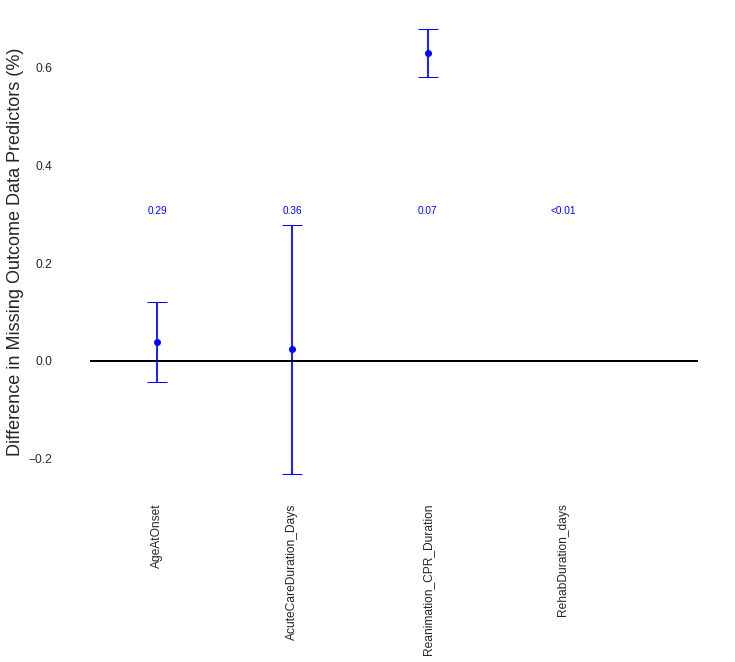

In [16]:
include = ['AgeAtOnset', 'AcuteCareDuration_Days', 'Reanimation_CPR_Duration', 'RehabDuration_days']
#X = data[include]

# change to 'gco' for difference tests betwen good and poor outcome
outcome = 'outcome_missing'

test = difference_tests(data, include, outcome)

# Save Output
y = [test[i][2] for i in range(len(test)) ]
x = [test[i][0] for i in range(len(test)) ]
intervals = [test[i][3] for i in range(len(test)) ]
features_tstat = [test[i][0] for i in range(len(test))]
p_values = ["%.2f" % test[i][1] for i in range(len(test))]

# Plotting
plt.figure(figsize=(12,9))

plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'


# Create Error Bar
ax = plt.subplot(111)
(_, caps, _) = ax.errorbar(x=np.arange(0, len(x), 1) ,
             y=y, 
             yerr=[(i[1]/100 - i[0]/100)/2 for i in intervals], color='blue', fmt = 'o', capsize = 10)

# Add Zero Line
ax.hlines(xmin=-.5, xmax=len(x),
           y=0.0, 
           linewidth=2.0,
           color="black")

# Manually set x axis ticks
ax.set_xticks(np.arange(0, len(x), 1))
ax.set_xticklabels(features_tstat, rotation = 90, ha = 'center', multialignment = 'center')

# Label Graph
#ax.set_xlabel('Day of NSE Recording', fontsize = 18)
ax.set_ylabel('Difference in Missing Outcome Data Predictors (%)', fontsize = 18)

# Set error bars top and bottom horiztonal bars
for cap in caps:
    cap.set_markeredgewidth(1)

# Apply desplining
simpleaxis(ax)

# Add p-value annotation
for i in np.arange(0, len(x), 1):
    if np.float(p_values[i]) <= 0.01:
        ax.annotate('<0.01', (i, 0.3), fontsize = 10, color='blue', ha='center')
    else:
        ax.annotate(p_values[i], (i, 0.3), fontsize = 10, color='blue', ha='center')
    
# Save Figure
plt.savefig('Write/missing_data_outcome.png', pad_inches = 10)
plt.show()

# KNN Imputation

In [21]:
import pandas as pd
import numpy as np
from fancyimpute import KNN
import seaborn as sns
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import scipy.stats

Using TensorFlow backend.


# Plot Boxplots of Raw Data

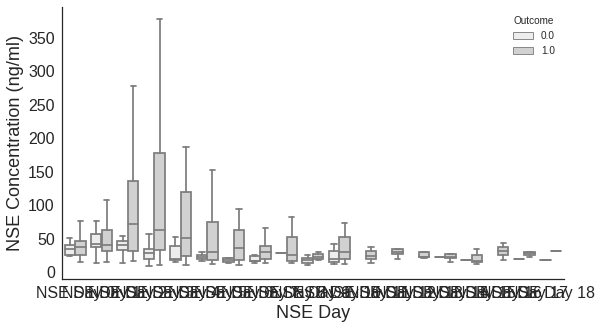

In [27]:
features = raw.columns[1:]
fig = plt.figure(figsize = (9, 5))
raw_melt = pd.melt(raw.reset_index(), id_vars=['gco'],value_vars=features, var_name='NSE Day', value_name='NSE')
sns.set_style("white") 
g = sns.boxplot(x="NSE Day", y="NSE", hue='gco', data=raw_melt, showfliers = False)
g.set_ylabel('NSE Concentration (ng/ml)', fontsize = 18)
g.set_xlabel('NSE Day', fontsize = 18)
g.set_xticklabels(features, fontsize = 16)
g.set_yticklabels(range(-50, 400, 50), fontsize = 16)
g.legend(title = 'Outcome')
simpleaxis(g)
#plt.savefig('Write/true_distribution.png', pad_inches = 2)
plt.show()

# Single Imputation - KNN 

In [28]:
to_impute = data[data.columns[21:-1]]
imputed_KNN = KNN(k=10).complete(to_impute)
# add outcome to dataframe
df_imputed_KNN = pd.DataFrame(imputed_KNN)
df_imputed_KNN.insert(0, 'gco', list(data['gco']))
df_imputed_KNN.columns = raw.columns
#df_imputed_KNN

Imputing row 1/126 with 15 missing, elapsed time: 0.021
Imputing row 101/126 with 14 missing, elapsed time: 0.066
[KNN] Warning: 50/2394 still missing after imputation, replacing with 0


# Plot Boxplots of Imputed Data

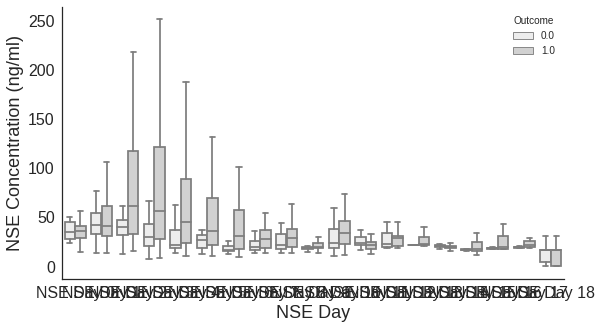

In [29]:
fig = plt.figure(figsize = (9, 5))
df_melt = pd.melt(df_imputed_KNN.reset_index(), id_vars=['gco'],value_vars=features, var_name='class', value_name='NSE')
#df1.head()
sns.set_style("white")        
g = sns.boxplot(x="class", y="NSE", hue='gco', data=df_melt, showfliers = False)
g.set_ylabel('NSE Concentration (ng/ml)', fontsize = 18)
g.set_xlabel('NSE Day', fontsize = 18)
g.set_xticklabels(features, fontsize = 16)
g.set_yticklabels(range(-50, 300, 50), fontsize = 16)
g.legend(title = 'Outcome')
simpleaxis(g)
#plt.savefig('Write/KNN_distribution.png', pad_inches = 2)
plt.show()

/home/emily/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:822: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(d1._var / (d1.nobs-1) + d2._var / (d2.nobs-1))
/home/emily/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:846: RuntimeWarning: invalid value encountered in double_scalars
  sem1 = d1._var / (d1.nobs-1)
/home/emily/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:4911: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
/home/emily/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:132: RuntimeWarning: invalid value encountered in double_scalars
  return self.sum / self.sum_weights
/home/emily/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:187: RuntimeWarning: invalid value encountered in double_scalars
  return self.sumsquares / self.sum_weights
/home/emily/anaconda3/lib/python3.6/site-packages/matplotlib/cboo

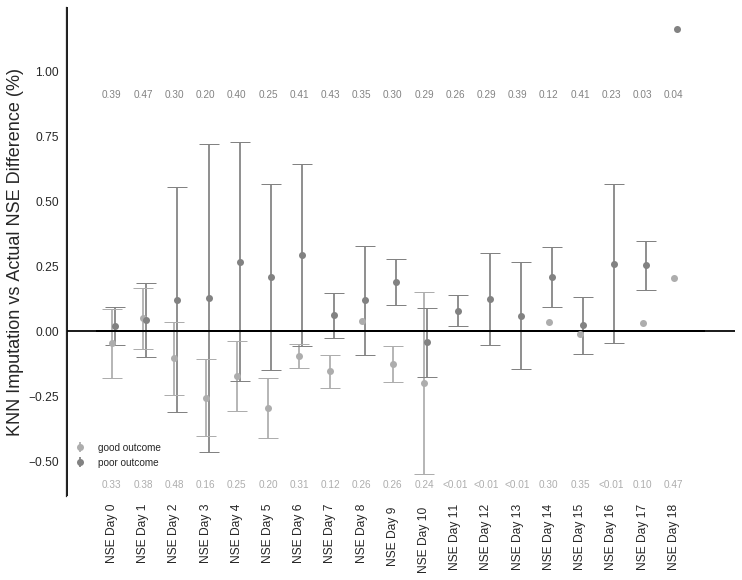

In [31]:
df1 = raw
df2 = df_imputed_KNN
outcome = 'gco'

# compare outcome class poor
test = []
for i in features:
    sample0 = df1.loc[df1[outcome] == 1][i].dropna()
    sample1 = df2.loc[df2[outcome] == 1][i].dropna()
    stat, pvalue = scipy.stats.mannwhitneyu(sample1, sample0)
    d0 = sms.DescrStatsW(sample0)
    d1 = sms.DescrStatsW(sample1)
    cm = sms.CompareMeans(d0, d1)
    CI = cm.tconfint_diff(usevar='unequal')
    
    if np.isnan(stat):
        pass
    else:
        test.append([i, pvalue, (d0.mean - d1.mean)/d1.mean, CI])
        
#test = difference_tests(df1, features, outcome)
        
y = [test[i][2] for i in range(len(test)) ]
x = [test[i][0] for i in range(len(test)) ]
intervals = [test[i][3] for i in range(len(test)) ]
features_tstat = [test[i][0] for i in range(len(test))]
p_values = ["%.2f" % test[i][1] for i in range(len(test))]

# compare outcome class good
outcome = 'gco'
test2 = []
for i in features:
    sample0 = df1.loc[df1[outcome] == 0][i].dropna()
    sample1 = df2.loc[df2[outcome] == 0][i].dropna()
    stat, pvalue = scipy.stats.mannwhitneyu(sample1, sample0)
    d0 = sms.DescrStatsW(sample0)
    d1 = sms.DescrStatsW(sample1)
    cm = sms.CompareMeans(d0, d1)
    CI = cm.tconfint_diff(usevar='unequal')
    
    if np.isnan(stat):
        pass
    else:
        test2.append([i, pvalue, (d0.mean - d1.mean)/d1.mean, CI])
        
#test2 = difference_tests(df2, features, outcome)
        
y2 = [test2[i][2] for i in range(len(test2)) ]
x2 = [test2[i][0] for i in range(len(test2)) ]
intervals2 = [test2[i][3] for i in range(len(test2)) ]
features_tstat2 = [test2[i][0] for i in range(len(test2))]
p_values2 = ["%.2f" % test2[i][1] for i in range(len(test2))]


# plots
plt.figure(figsize=(12,9))

plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

# Remove Splines
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

color1 = seq_col_brew[2]
color2 = seq_col_brew[3]

# Create Error Bar for good Outcome class
ax = plt.subplot(111)
(_, caps, _) = ax.errorbar(x=np.arange(0, len(x2), 1) ,
             y=y2, 
             yerr=[(i[1]/100 - i[0]/100)/2 for i in intervals2], color=color1, fmt = 'o', capsize = 10)

ax.legend(labels=['poor outcome'], loc = (0,0.1))

# Create Error Bar for poor outcome class
ax2 = plt.subplot(111)
(_, caps2, _) = ax2.errorbar(x=np.arange(0, len(x), 1)+0.1 ,
             y=y, 
             yerr=[(i[1]/100 - i[0]/100)/2 for i in intervals], color=color2, fmt = 'o', capsize = 10)

ax2.legend(labels=['good outcome','poor outcome'], loc = (0,0.05))
# Add Zero Line
ax.hlines(xmin=-.5, xmax=len(x),
           y=0.0, 
           linewidth=2.0,
           color="black")

# Manually set x axis ticks
ax.set_xticks(np.arange(0, len(x), 1))
ax.set_xticklabels(features_tstat, rotation = 90, ha = 'center', multialignment = 'center')

# Label Graph
#ax.set_xlabel('Day of NSE Recording', fontsize = 18)
ax.set_ylabel('KNN Imputation vs Actual NSE Difference (%)', fontsize = 18)

# Set error bars top and bottom horiztonal bars
for cap in caps:
    cap.set_markeredgewidth(1)
for cap in caps2:
    cap.set_markeredgewidth(1)

# Apply desplining
simpleaxis(ax)
ax.axhline(y=0, color='black')
ax.axvline(x=-1.45, color='k')

# Add p-value annotation
for i in np.arange(0, len(x), 1):
    if np.float(p_values[i]) <= 0.01:
        ax.annotate('<0.01', (i, 0.9), fontsize = 10, color=color1, ha='center')
    else:
        ax.annotate(p_values[i], (i, 0.9), fontsize = 10, color=color2, ha='center')
    
for i in np.arange(0, len(x2), 1):
    if np.float(p_values2[i]) <= 0.01:
        ax.annotate('<0.01', (i, -0.6), fontsize = 10, color=color1, ha='center')
    else:
        ax.annotate(p_values2[i], (i, -0.6), fontsize = 10, color=color1, ha='center')
        
#ax.legend(labels=['poor outcome', 'good outcome'], loc = 3)
#leg = ax.get_legend()
#leg
#leg.legendHandles[0].set_color(color2)
#leg.legendHandles[1].set_color(color1)
#leg.legendHandles[0].set_marker('*')
#leg.legendHandles[1].set_marker('*')
# Save Figure
plt.savefig('Write/final/KNN_imputation.png', pad_inches = 10)
plt.show()

# Machine Learning Implementation

In [32]:
from fancyimpute import KNN
from sklearn.metrics import confusion_matrix
from operator import itemgetter
import pandas as pd
import numpy as np

## Impute Data

In [40]:
n = 21 + 17
for k in range(1, 2, 1):
    to_impute = data[data.columns[22:n]]
    imputed = KNN(k=9).complete(to_impute)
    df = pd.DataFrame(imputed)
    df.columns = data.columns[22:n]
    df.insert(0, 'gco', list(data['gco']))
    X = imputed
    y = df[outcome].as_matrix()

Imputing row 1/126 with 12 missing, elapsed time: 0.015
Imputing row 101/126 with 11 missing, elapsed time: 0.053
[KNN] Warning: 18/2016 still missing after imputation, replacing with 0


In [41]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

## Functions

In [43]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
import pandas as pd

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

from sklearn.calibration import calibration_curve
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.metrics import brier_score_loss

def roc_analysis(y_true, feature):
    fpr = []
    tpr = []
    thresholds = []
    minimum = min(feature)
    maximum = max(feature)
    jouden = []
    aucs = []
    for i in np.arange(minimum, maximum, 0.01):
        y_pred = [1 if j > i else 0 for j in feature]
        fpr_, tpr_, _ = roc_curve(y_true, y_pred)
        auc_obj = auc(fpr_, tpr_)
        aucs.append(auc_obj)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        thresholds.append(i)
        fpr.append(fp/(fp + tn))
        tpr.append(tp/(tp + fn))
        jouden.append(tp/(tp + fn) - fp/(fp + tn))
        
    jouden_index = max(enumerate(jouden), key=itemgetter(1))[0]
    jouden_value = max(enumerate(jouden), key=itemgetter(1))[1]
    cut_off = thresholds[jouden_index]
    sensitivity = tpr[jouden_index]
    specificity = 1-fpr[jouden_index]
    
    y_pred = [1 if j > cut_off else 0 for j in feature]
    cm = confusion_matrix(y_true, y_pred)
    return aucs[jouden_index],jouden_value, cut_off, sensitivity, specificity, cm

def simpleaxis(ax):
    # plot settings
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    seq_col_brew = sns.color_palette('Greys')
    plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=12)  
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    return seq_col_brew
    
def ROC_plots_calibrate(X, y, n_splits, classifiers, names):
    random_state = np.random.RandomState(0)
    #sss = StratifiedShuffleSplit(y, n_splits, test_size=0.5, random_state=random_state)
    cv = StratifiedKFold(n_splits, random_state=random_state)
    
    name = -1
    
    fig, ax = plt.subplots()
    seq_col_brew = simpleaxis(ax)
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='k')
    
    # for calibration plots
    prob = []
    actual = []
    for classifier in classifiers:
        name += 1
        # Run classifier with cross-validation and plot ROC curves
        #cv = StratifiedKFold(n_splits)
        classifier = classifier

        tprs = []
        aucs = []
        models = []

        # for calibration
        kfold_prob = []
        kfold_true = []

        mean_fpr = np.linspace(0, 1, 100)
        #thresholdsall = []
        i = 0
        for train, test in cv.split(X,y):        
            model = classifier.fit(X[train], y[train])
            probas_ = model.predict_proba(X[test])

            # Add probabilities for calibration
            kfold_prob.append(probas_[:,1])
            kfold_true.append(y[test])

            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
            #thresholdsall.append(thresholds)
            #print (Find_Optimal_Cutoff(y[test], probas_[:,1]))
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            #plt.plot(fpr, tpr, lw=1, alpha=0.3,
            #         label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

            i += 1
            models.append(model)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(mean_fpr, mean_tpr, color=seq_col_brew[name],
                 label= names[name] +' (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        #plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
        #                label=r'$\pm$ 1 std. dev.')
        
        prob_stacked = np.hstack(kfold_prob)
        actual_stacked = np.hstack(kfold_true)
        prob.append(prob_stacked)
        actual.append(actual_stacked)        

    ax.plot([0, 1], [0, 1], lw=2, color='black', linestyle='--',label='Luck', alpha=.8)
    #ax.xlim([-0.05, 1.05])
    #ax.ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize = 18)
    ax.set_ylabel('True Positive Rate', fontsize = 18)
    #plt.title('Receiver operating characteristic example')
    ax.legend(loc = (0.55, 0.1))
    #ax.gray()
    #plt.savefig('Write\final\ROC_prediction_models.png')
    plt.show()
    fig2 = calibration_plots_many(prob,actual, names)
    return fig, fig2, prob, actual

def calibration_plots_many(prob, actual, names):
    fig, ax = plt.subplots()
    seq_col_brew = simpleaxis(ax)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    for i in range(len(prob)):
        actual_stacked = actual[i]
        prob_stacked = prob[i]

        #print (bin_total(actual_stacked, prob_stacked, 5))
        
        score = brier_score_loss(actual_stacked, prob_stacked)
        y, x = calibration_curve(actual_stacked, prob_stacked, n_bins=5)

        # calibration curves
        ax.plot(x,y, marker='o', linewidth=1, label=names[i] + ' (%0.2f)' % score, color=seq_col_brew[i])
    #plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='rf')

    # reference line, legends, and axis labels
    line = mlines.Line2D([0, 1], [0, 1], linestyle='--', color='black', label = 'Perfect Calibration')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    #ax.subtitle('Calibration plot for Titanic data')
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xlabel('Predicted probability', fontsize = 18)
    ax.set_ylabel('True probability in each bin', fontsize = 18)
    plt.legend(loc = (0.7, 0.1))
    #plt.savefig('Write\final\calibration_prediction_models.png')
    plt.show()
    return fig

def bin_total(y_true, y_prob, n_bins):
    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1
    return np.bincount(binids, minlength=len(bins))

# Implement Machine Learning Algorithms

In [44]:
names = ["Nearest Neighbors", "Linear SVM",
         "Naive Bayes", "LogRes"]

classifiers = [
    KNeighborsClassifier(9),
    SVC(kernel="linear", C=0.025, probability = True),
    GaussianNB(), LogisticRegression()]

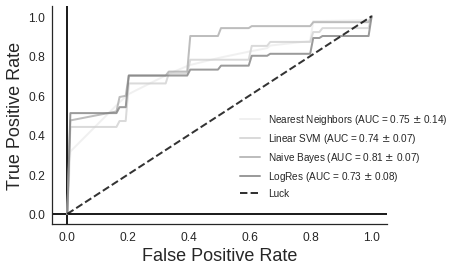

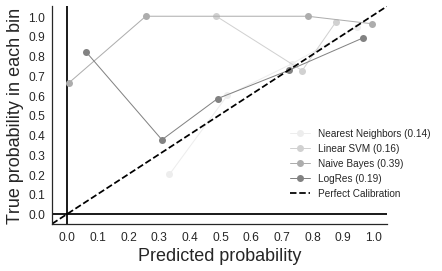

In [45]:
fig, fig2, prob, actual = ROC_plots_calibrate(X, y, 5, classifiers, names)
#fig.savefig('ROC_prediction_models.png')
#fig2.savefig('calibration_prediction_models.png')

In [47]:
# Obtain >95% sensitivity
sensitivity = {}
for z in range(4):
    analysis = []
    for theta in np.arange(0,1.1,0.01):
        y_score = [1 if i >= theta else 0 for i in prob[z]]
        y_ = actual[z]
        tn, fp, fn, tp = confusion_matrix(y_, y_score).ravel()
        fpr = fp/(fp + tn)
        tpr = tp/(tp + fn)
        if 1 - fpr >= 0.95:
            analysis.append((theta, tpr, 1-fpr))
            break
    sensitivity[classifiers[z]] = analysis

# obtain jouden cut-off index
cut_offs = []
for z in range(4):
    aucs, jouden_value, cut_off, sensitivity, specificity, cm = roc_analysis(actual[z], prob[z])
    cut_offs.append((aucs, cut_off, sensitivity, specificity, cm ))

## Calibration

In [48]:
# Calibration Classifiers
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
names = ["Naive Bayes", "Naive Bayes + Isotonic", "Naive Bayes + Sigmoid"]
est = GaussianNB()
classifiers = [est, CalibratedClassifierCV(est, cv=5, method='isotonic'),CalibratedClassifierCV(est, cv=5, method='sigmoid')]

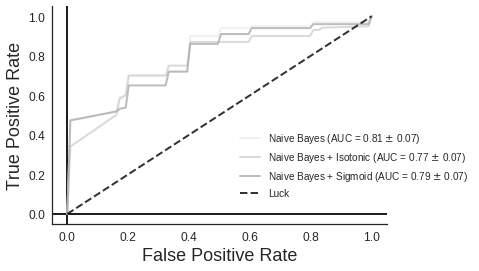

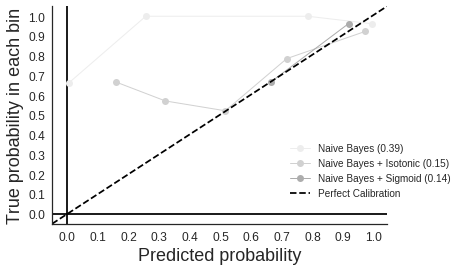

In [49]:
fig, fig2, prob, actual = ROC_plots_calibrate(X, y, 5, classifiers, names)
#fig.savefig('NB_prediction_models.png')
#fig2.savefig('calibration_NBprediction_models.png')

## Updated Function to Help Analyse Day 3

In [50]:
# output model 
def ROC_plots_calibrate(X, y, n_splits, classifiers, names):
    random_state = np.random.RandomState(0)
    #sss = StratifiedShuffleSplit(y, n_splits, test_size=0.5, random_state=random_state)
    cv = StratifiedKFold(n_splits, random_state=random_state)
    
    name = -1
    
    fig, ax = plt.subplots()
    seq_col_brew = simpleaxis(ax)
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='k')
    
    # for calibration plots
    prob = []
    actual = []
    for classifier in classifiers:
        name += 1
        # Run classifier with cross-validation and plot ROC curves
        #cv = StratifiedKFold(n_splits)
        classifier = classifier

        tprs = []
        aucs = []
        models = []

        # for calibration
        NSE_day4 = []
        kfold_prob = []
        kfold_true = []
        indices = []

        mean_fpr = np.linspace(0, 1, 100)
        #thresholdsall = []
        i = 0
        for train, test in cv.split(X,y):        
            model = classifier.fit(X[train], y[train])
            probas_ = model.predict_proba(X[test])
            
            # Get NSE day 4 values
            NSE_day4.append(X[test][:,3])
            indices.append(list(test))

            # Add probabilities for calibration
            kfold_prob.append(probas_[:,1])
            kfold_true.append(y[test])

            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
            #thresholdsall.append(thresholds)
            #print (Find_Optimal_Cutoff(y[test], probas_[:,1]))
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            #plt.plot(fpr, tpr, lw=1, alpha=0.3,
            #         label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

            i += 1
            models.append(model)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(mean_fpr, mean_tpr, color=seq_col_brew[name],
                 label= names[name] +' (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        #plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
        #                label=r'$\pm$ 1 std. dev.')
        
        prob_stacked = np.hstack(kfold_prob)
        actual_stacked = np.hstack(kfold_true)
        NSE_stacked = np.hstack(NSE_day4)
        prob.append(prob_stacked)
        actual.append(actual_stacked)        

    ax.plot([0, 1], [0, 1], lw=2, color='black', linestyle='--',label='Luck', alpha=.8)
    #ax.xlim([-0.05, 1.05])
    #ax.ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize = 18)
    ax.set_ylabel('True Positive Rate', fontsize = 18)
    #plt.title('Receiver operating characteristic example')
    ax.legend(loc = (0.55, 0.1))
    #ax.gray()
    #plt.savefig('Write\final\ROC_prediction_models.png')
    plt.show()
    fig2 = calibration_plots_many(prob,actual,names)
    return fig, fig2, prob, actual, prob_stacked, actual_stacked, NSE_stacked, indices

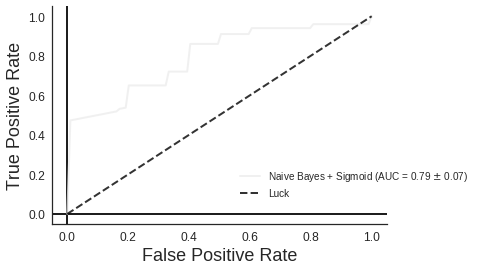

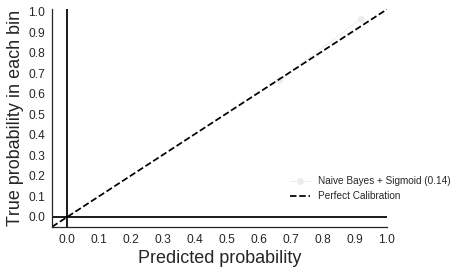

In [51]:
names = ["Naive Bayes + Sigmoid"]
est = GaussianNB()
classifiers = [CalibratedClassifierCV(est, cv=5, method='sigmoid')]
fig, fig2, prob, actual, prob, actual, NSE, indices = ROC_plots_calibrate(X, y, 5, classifiers, names)

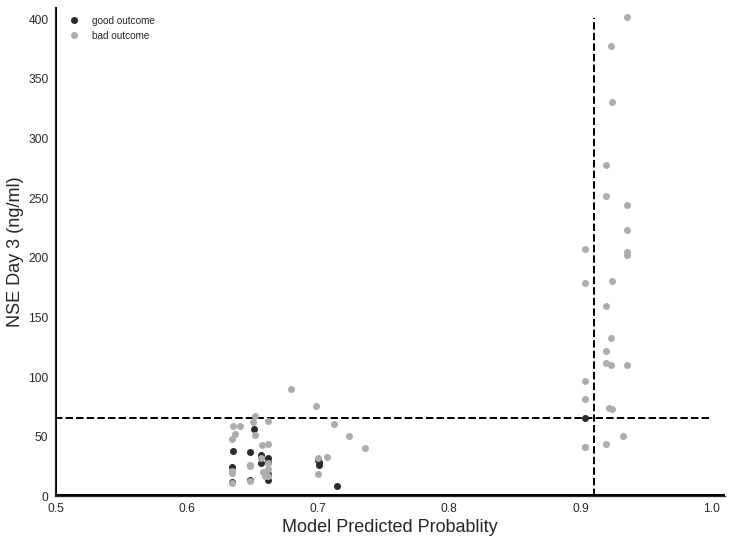

In [52]:
indices = indices[0]+indices[1]+indices[2]+indices[3]+indices[4]
NSE_Day4 = [data[['NSE Day 4']].as_matrix()[i][0] for i in indices]
discussion = pd.DataFrame(list(zip(actual, prob, NSE, NSE_Day4)), columns = ['actual', 'prob', 'NSE', 'NSE_Day4'])
groups = discussion.groupby(actual)
plt.figure(figsize=(12,9))
ax = plt.subplot(111)

# Desplining
seq_col_brew = simpleaxis(ax)
ax.axhline(y=-0.05, color='k', linewidth=4.0)
ax.axvline(x=0.5, color='k',  linewidth=4.0)


# Scatterplot
for name, group in groups:
    if name == 0.0:
        actual_name = 'good outcome'
    else:
        actual_name = 'bad outcome'
    ax.plot(group['prob'], group['NSE_Day4'], label = actual_name, marker='o', linestyle=' ', color = seq_col_brew[int(name)*3-1])
ax.legend()

# Label Graph
ax.set_xlabel('Model Predicted Probablity', fontsize = 18)
ax.set_ylabel('NSE Day 3 (ng/ml)', fontsize = 18)

# Draw Cut-Offs
ax.set_ylim(0,410)
ax.set_xlim(0.5,1.01)
ax.hlines(xmin=0.5, xmax=1,
           y=65, 
           linewidth=2.0,
           color="black", linestyle='--')
ax.vlines(ymin=0, ymax=400,
           x=.91, 
           linewidth=2.0,
           color="black", linestyle='--')
plt.rc('xtick', labelsize=18)  
plt.rc('ytick', labelsize=18)  
# Save Figure
plt.savefig('Write/comparing_day_4.png', pad_inches = 2)
plt.show()

In [53]:
discussion_nonna = discussion.dropna(axis = 0, how='any')
from sklearn.metrics import roc_curve, auc
from operator import itemgetter
def roc_analysis(y_true, feature):
    fpr = []
    tpr = []
    thresholds = []
    minimum = min(feature)
    maximum = max(feature)
    jouden = []
    aucs = []
    for i in np.arange(int(minimum), int(maximum), 0.1):
        y_pred = [1 if j > i else 0 for j in feature]
        fpr_, tpr_, _ = roc_curve(y_true, y_pred)
        auc_obj = auc(fpr_, tpr_)
        aucs.append(auc_obj)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        thresholds.append(i)
        fpr.append(fp/(fp + tn))
        tpr.append(tp/(tp + fn))
        jouden.append(tp/(tp + fn) - fp/(fp + tn))
        
    jouden_index = max(enumerate(jouden), key=itemgetter(1))[0]
    jouden_value = max(enumerate(jouden), key=itemgetter(1))[1]
    cut_off = thresholds[jouden_index]
    sensitivity = tpr[jouden_index]
    specificity = 1-fpr[jouden_index]
    
    
    
    y_pred = [1 if j > cut_off else 0 for j in feature]
    cm = confusion_matrix(y_true, y_pred)
    return aucs[jouden_index],jouden_value, cut_off, sensitivity, specificity, cm, fpr, tpr, thresholds
    #return thresholds, fpr, tpr, aucs,

In [54]:
aucs, jouden, cut_off, sensitivity, specificity, cm, fpr, tpr, thresholds = roc_analysis(discussion_nonna['actual'], discussion_nonna['NSE_Day4'])

In [55]:
auc(fpr, tpr)

0.75364298724954459

In [56]:
1-fpr[570], tpr[570], thresholds[570]

(1.0, 0.47540983606557374, 64.999999999999801)